<center><h3>EDA</h3></center>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import folium
sns.set()

In [3]:
data_purchases = pd.read_csv(r"credit_card_purchases.csv")

In [3]:
data_purchases.drop(columns=['Unnamed: 0', 'first','last','street','cc_num','cc_num','trans_num','city_pop','zip','unix_time','merch_zipcode','merch_long','merch_lat'], inplace=True)

In [4]:
data_purchases['trans_date_trans_time'] = pd.to_datetime(data_purchases['trans_date_trans_time'], errors='coerce')

In [5]:
colors = [
    '#440154',  # Original
    '#482878',  # Original
    '#3e4a8b',  # Original
    '#31688e',  # Original
    '#26828e',  # Original
    '#1f9e89',  # Original
    '#35b779',  # Original
    '#6cda9f',  # Original
    '#aadc32',  # Original
    '#f5c851',  # Original
    '#d8c8a7',  # Más oscuro que '#f7f0e1'
    '#d0d0d0',  # Más oscuro que '#f7f7f7'
    '#d1d1d1',  # Más oscuro que '#f0f0f0'
    '#bcbcbc',  # Más oscuro que '#e6e6e6'
]


Product categories with the highest demand

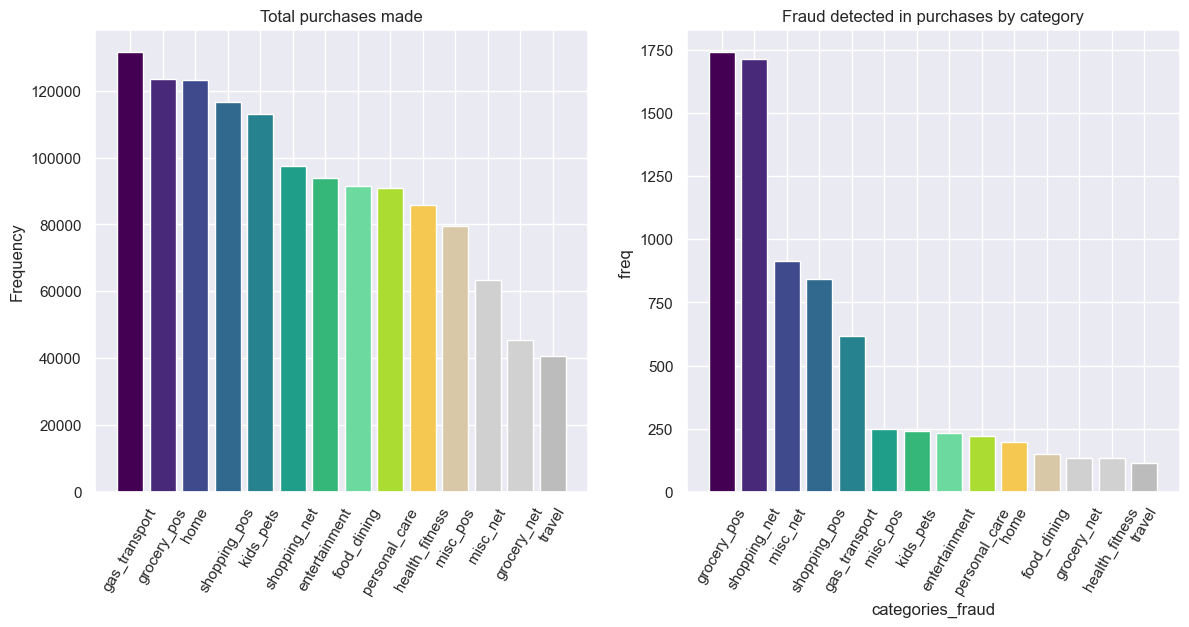

In [6]:
frec_cat = data_purchases['category'].value_counts().reset_index()
# Graficar barras con color usando la paleta 'viridis'
fig, ax = plt.subplots(1,2,figsize=(14, 6))

# Graficar barras con color usando la paleta 'viridis'
ax[0].bar(data=frec_cat, x='category', height='count', color= colors)
# Añadir título y ajustar las etiquetas del eje x
ax[0].set_title("Frequency of Consumer Card Demand")
ax[0].set_ylabel('Frequency')
ax[0].set_title("Total purchases made")
ax[0].tick_params(axis='x', rotation=60)  # Rotar las etiquetas del eje x

fraud_cat = data_purchases[['category','is_fraud']].query('is_fraud==1').value_counts().reset_index().rename({'count':'conteo'}, axis=1)[['category','conteo']]

ax[1].set_title('Fraud detected in purchases by category')
ax[1].bar(data=fraud_cat, x='category',height='conteo', color= colors)
ax[1].set_ylabel('freq ')
ax[1].set_xlabel('categories_fraud')
ax[1].tick_params(axis='x', rotation=60)  # Rotar las etiquetas del eje x

# Mostrar el gráfico
plt.show()

Average amount per category per month

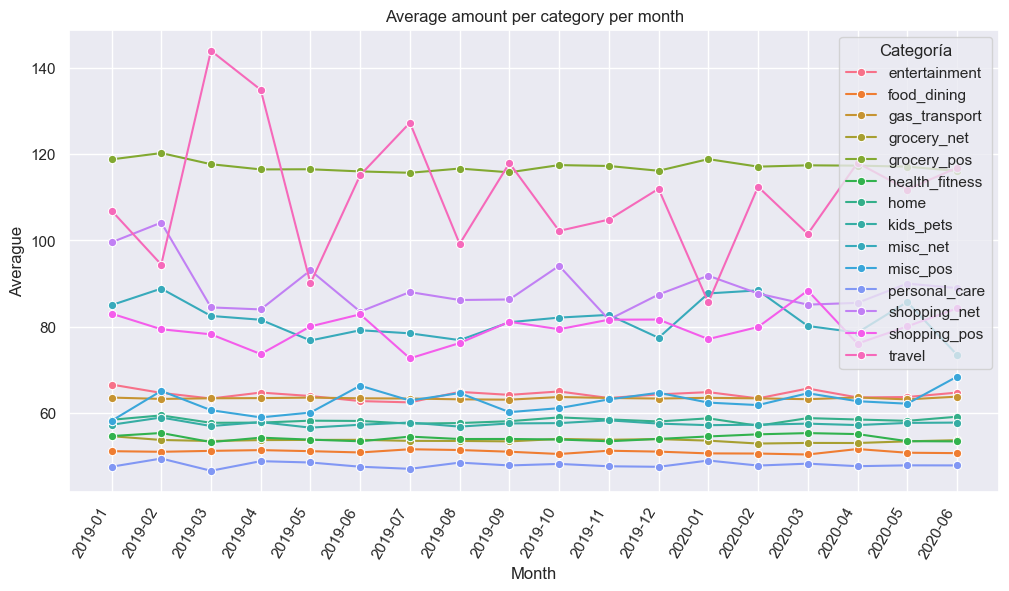

In [7]:
data_purchases['YearMonth'] = data_purchases['trans_date_trans_time'].dt.to_period('M')

grouped_cat_month = data_purchases[['trans_date_trans_time', 'category', 'amt', 'YearMonth']].groupby(['category', 'YearMonth'])['amt'].mean().reset_index()

grouped_cat_month['YearMonth'] = grouped_cat_month['YearMonth'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_cat_month, x='YearMonth', y='amt', hue='category', marker='o')
plt.title("Average amount per category per month")
plt.xlabel('Month')
plt.ylabel('Averague')
plt.xticks(rotation=60, ha='right')
plt.legend(title='Categoría')
plt.show()

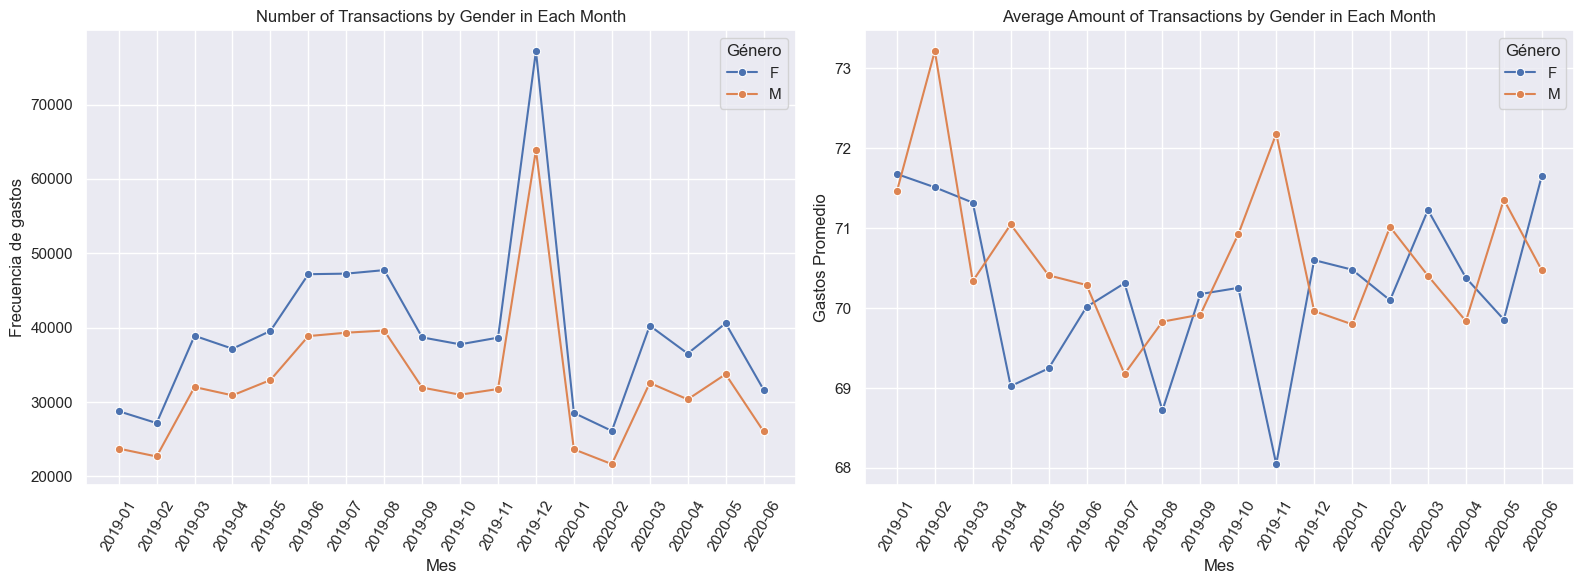

In [8]:

grouped_count = data_purchases[['YearMonth', 'gender']].groupby(['YearMonth', 'gender']).size().reset_index(name='count')
grouped_amount = data_purchases[['YearMonth', 'gender', 'amt']].groupby(['YearMonth', 'gender'])['amt'].mean().reset_index()

# Convertir YearMonth a string si es necesario
grouped_count['YearMonth'] = grouped_count['YearMonth'].astype(str)
grouped_amount['YearMonth'] = grouped_amount['YearMonth'].astype(str)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Primer gráfico: Número de transacciones por género en cada mes
sns.lineplot(data=grouped_count, x='YearMonth', y='count', hue='gender', marker='o', ax=ax[0])
ax[0].set_title("Number of Transactions by Gender in Each Month")
ax[0].set_xlabel('Mes')
ax[0].set_ylabel('Frecuencia de gastos')
ax[0].tick_params(axis='x', rotation=60)
ax[0].legend(title='Género')

# Segundo gráfico: Monto promedio de transacciones por género en cada mes
sns.lineplot(data=grouped_amount, x='YearMonth', y='amt', hue='gender', marker='o', ax=ax[1])
ax[1].set_title("Average Amount of Transactions by Gender in Each Month")
ax[1].set_xlabel('Mes')
ax[1].set_ylabel('Gastos Promedio')
ax[1].tick_params(axis='x', rotation=60)
ax[1].legend(title='Género')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


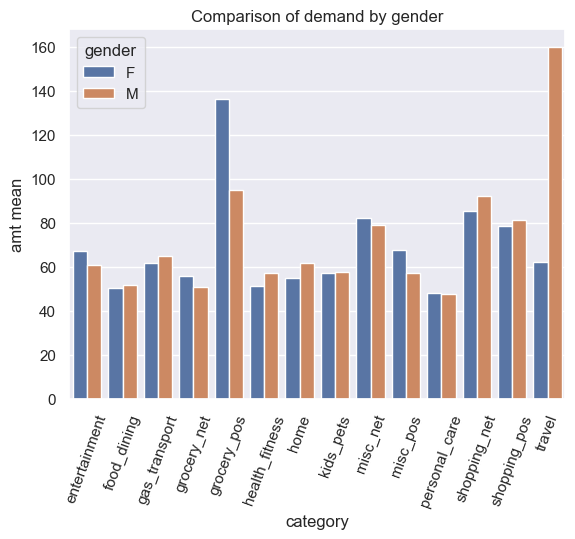

In [9]:
data_cat_gen_amt = data_purchases[['gender','amt', 'category']].groupby(['gender','category'])['amt'].mean().reset_index()

sns.barplot(data=data_cat_gen_amt, x='category',y='amt', hue='gender')
plt.title('Comparison of demand by gender')
plt.ylabel('amt mean')
plt.xticks(rotation=70)
plt.show()

In [10]:

# Agrupación y cálculo de estadísticas
grouping_city = data_purchases[['state', 'lat', 'long']].groupby('state').agg(
    lat=('lat', 'mean'),
    long=('long', 'mean'),
    count_city=('state', 'size')
).reset_index()

# Crear el mapa
eeuu_map = folium.Map(location=[37.09024, -95.712891], zoom_start=4, tiles='CartoDB dark_matter')

# Encontrar los 3 estados con el mayor conteo
top_3_states = grouping_city.nlargest(3, 'count_city')['state'].tolist()

# Añadir CircleMarkers al mapa
for row_data in grouping_city.itertuples(index=False):
    color = 'blue'  # Color por defecto para los círculos
    if row_data.state in top_3_states:
        color = 'white'  # Color especial para los 3 círculos más grandes
    
    folium.CircleMarker(
        location=[row_data.lat, row_data.long],
        radius=row_data.count_city / 2400,  # Ajustar el tamaño del círculo
        color=color,
        fill_opacity=0.6,
        fill=True,
        opacity=1,
        tooltip='State: {state} \n Total Transactions between 2019-2020: {total}'.format(state=row_data.state, total= (data_purchases['state']==row_data.state).sum()),
        stroke=False
    ).add_to(eeuu_map)

# Mostrar el mapa
eeuu_map


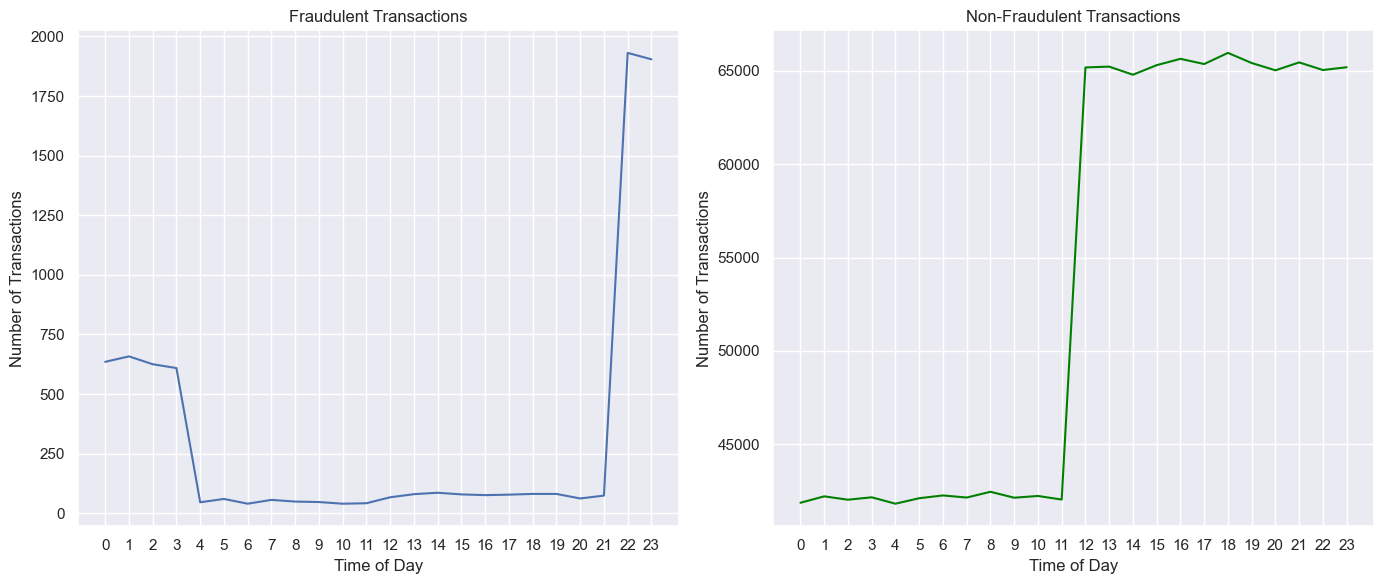

In [11]:
data_fraud_not = data_purchases.query('is_fraud == 0')['trans_date_trans_time'].dt.hour.value_counts().reset_index()
data_fraud_not.columns = ['hour', 'count']
data_fraud_not = data_fraud_not.sort_values(by='hour')

data_fraud = data_purchases.query('is_fraud == 1')['trans_date_trans_time'].dt.hour.value_counts().reset_index()
data_fraud.columns = ['hour', 'count']

data_fraud = data_fraud.sort_values(by='hour')

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico para transacciones fraudulentas
ax[0].plot(data_fraud['hour'], data_fraud['count'])
ax[0].set_title('Fraudulent Transactions')
ax[0].set_xlabel('Time of Day')
ax[0].set_ylabel('Number of Transactions')
ax[0].set_xticks(data_fraud['hour']) 

# Gráfico para transacciones no fraudulentas
ax[1].plot(data_fraud_not['hour'],data_fraud_not['count'], color='green')
ax[1].set_title('Non-Fraudulent Transactions')
ax[1].set_xlabel('Time of Day')
ax[1].set_ylabel('Number of Transactions')
ax[1].set_xticks(data_fraud_not['hour']) 

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()



In [12]:
data_purchases['hour'] = data_purchases['trans_date_trans_time'].dt.hour

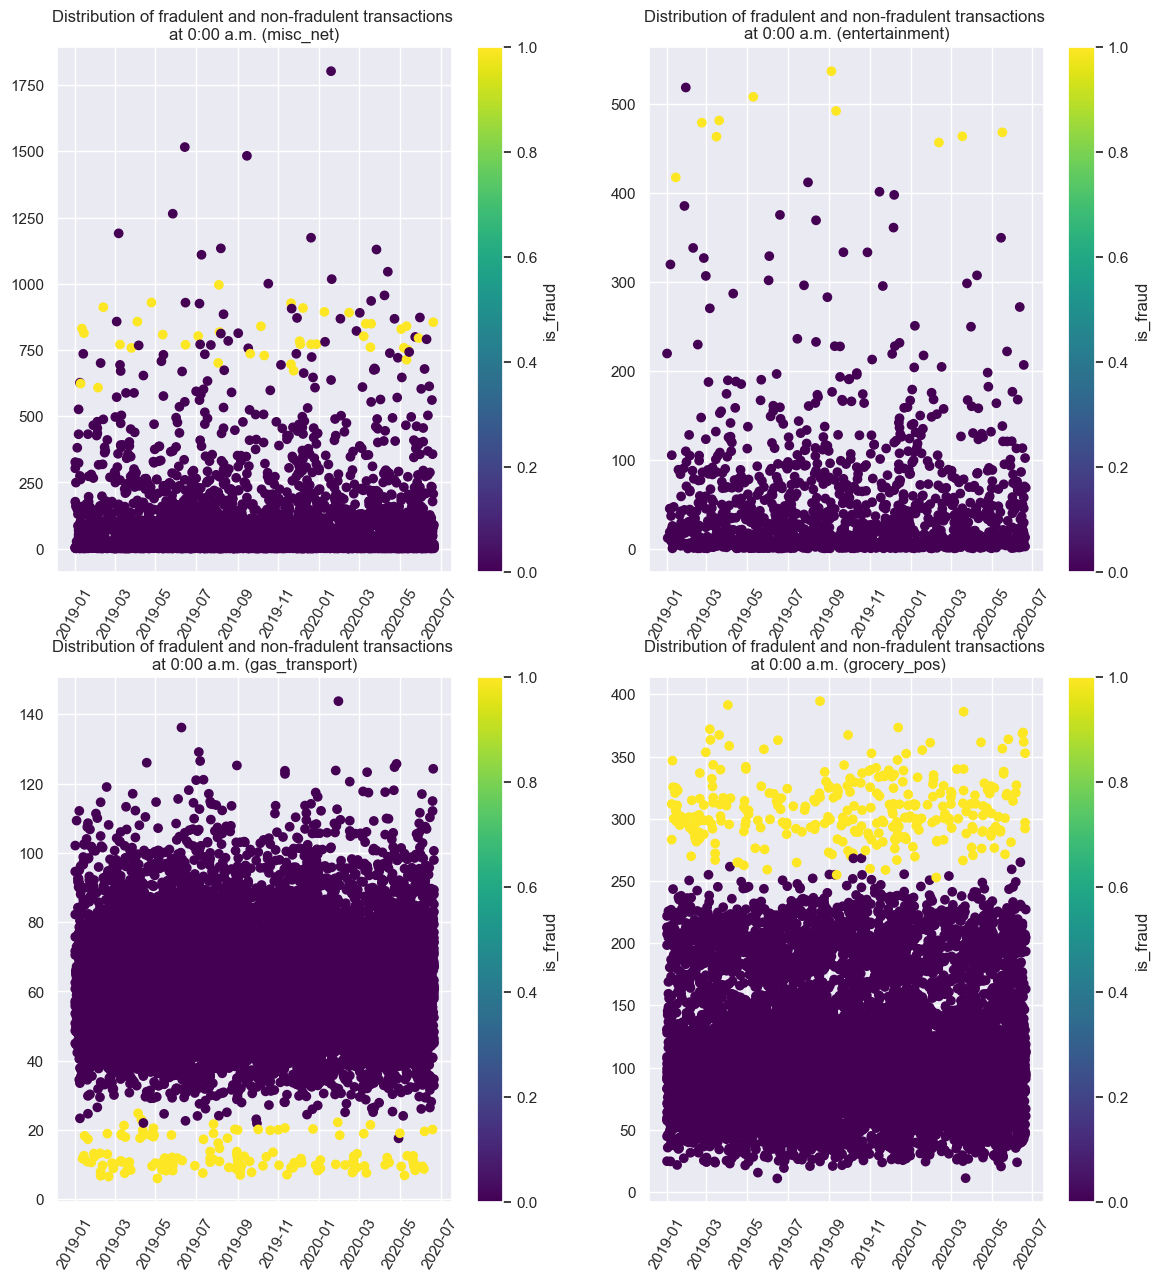

In [13]:
fig, ax = plt.subplots(2,2, figsize=(14,15))

filtered_data = data_purchases.query('category=="misc_net" and hour==0')

# Crear gráfico de dispersión usando `c` para color y `marker` para forma
scatter_1 = ax[0, 0].scatter(x=filtered_data['trans_date_trans_time'], 
                           y=filtered_data['amt'], 
                           c=filtered_data['is_fraud'],
                           cmap='viridis')                   # Forma de los puntos
ax[0,0].set_title('Distribution of fradulent and non-fradulent transactions \nat 0:00 a.m. (misc_net)')
ax[0,0].tick_params(axis='x', rotation=60)

filtered_data = data_purchases.query('category=="entertainment" and hour==0')


scatter_2 = ax[0, 1].scatter(x=filtered_data['trans_date_trans_time'], 
                           y=filtered_data['amt'], 
                           c=filtered_data['is_fraud'],  # Colorear según `is_fraud`
                           cmap='viridis')                   # Forma de los puntos

ax[0,1].tick_params(axis='x', rotation=60)
ax[0,1].set_title('Distribution of fradulent and non-fradulent transactions \nat 0:00 a.m. (entertainment)')



filtered_data = data_purchases.query('category=="gas_transport" and hour==0')


scatter_3 = ax[1, 0].scatter(x=filtered_data['trans_date_trans_time'], 
                           y=filtered_data['amt'], 
                           c=filtered_data['is_fraud'],  # Colorear según `is_fraud`
                           cmap='viridis')                   # Forma de los puntos

ax[1,0].tick_params(axis='x', rotation=60)
ax[1,0].set_title('Distribution of fradulent and non-fradulent transactions \nat 0:00 a.m. (gas_transport)')


filtered_data = data_purchases.query('category=="grocery_pos" and hour==0')

scatter_4 = ax[1, 1].scatter(x=filtered_data['trans_date_trans_time'], 
                           y=filtered_data['amt'], 
                           c=filtered_data['is_fraud'],  # Colorear según `is_fraud`
                           cmap='viridis')                   # Forma de los puntos

ax[1,1].tick_params(axis='x', rotation=60)
ax[1,1].set_title('Distribution of fradulent and non-fradulent transactions \n at 0:00 a.m. (grocery_pos)')

# Añadir una barra de color para la variable `is_fraud`
fig.colorbar(scatter_1, ax=ax[0, 0], label='is_fraud')
fig.colorbar(scatter_2, ax=ax[0, 1], label='is_fraud')
fig.colorbar(scatter_3, ax=ax[1, 0], label='is_fraud')
fig.colorbar(scatter_4, ax=ax[1, 1], label='is_fraud')

plt.show()

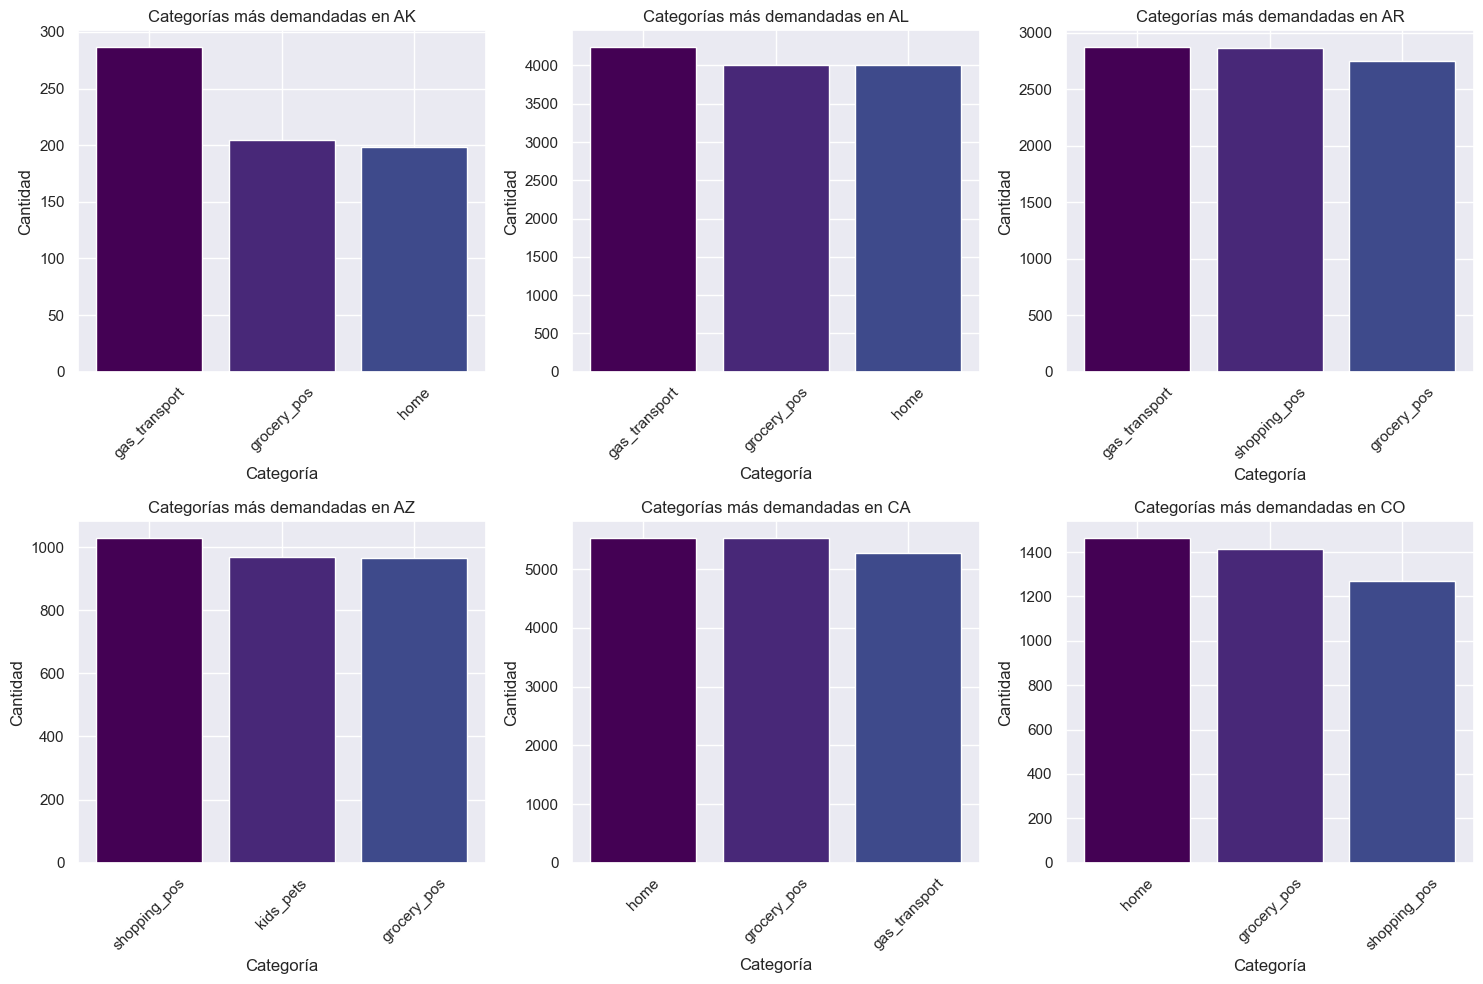

In [14]:
# Agrupar por 'state' y 'category' y contar las ocurrencias
grouped = data_purchases.groupby(['state', 'category']).size().reset_index(name='count')

# Ordenar por 'state' y luego por 'count' de forma descendente
grouped = grouped.sort_values(['state', 'count'], ascending=[True, False])

# Obtener las tres categorías con mayor demanda por cada estado
top_categories = grouped.groupby('state').head(3)

# Filtramos las 18 primeras filas
top_categories_filtered = top_categories.head(18)

# Obtenemos los estados únicos
states = top_categories_filtered['state'].unique()

# Creamos la figura y los ejes para 6 gráficos (2 filas, 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Iteramos sobre cada estado y creamos un gráfico de barras
for i, state in enumerate(states):
    # Filtramos los datos para el estado actual
    state_data = top_categories_filtered[top_categories_filtered['state'] == state]
    
    # Creamos el gráfico de barras en el eje correspondiente
    axes[i].bar(state_data['category'], state_data['count'], color=colors)
    
    # Añadimos título y etiquetas
    axes[i].set_title(f'Categorías más demandadas en {state}')
    axes[i].set_xlabel('Categoría')
    axes[i].set_ylabel('Cantidad')
    axes[i].tick_params(axis='x', rotation=45)

# Ajustamos el espacio entre gráficos
plt.tight_layout()
plt.show()
